ADSP 32001 IP01  
Dr. Mark Hendricks  
Spring 2024  
Ariel Azria, Sella Lin, Vincent Feng

<h1><center>Final Project</center></h1>
<center>Evaluating the returns on a pairwise trading strategy using the Nikkei 225 and the Stoxx 500</center>

*For information on dataset, and rationale behind why we used each ETF, please consult 'Data Pull for Final Project.ipynb'*

# ETF Price EDA

First, we will be conducting an EDA on the dataset to understand more about the ETFs.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader as pdr

In [3]:
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [4]:
STARTDATE = "1995-01-01"
ENDDATE = "2024-05-13"

In [5]:
TICKS = [
    # '1329.T',
    # '1321.T',
    'FEZ',
    # '^N225',
    # '^STOXX50E',
    'EWJ'
]

FLDS = ['quoteType','shortName','volume','totalAssets','trailingAnnualDividendYield','longBusinessSummary']

In [6]:
info = pd.DataFrame(index=TICKS,columns=FLDS)
info.index.name = 'ticker'
for tick in info.index:
    temp = yf.Ticker(tick).get_info()

    for fld in FLDS:
        if fld in temp.keys():
            info.loc[tick,fld] = temp[fld]

In [7]:
prices = yf.download(TICKS, start=STARTDATE, end=ENDDATE)['Adj Close'][info.index]
prices.index.name = 'date'
prices.dropna(inplace=True)

[*********************100%%**********************]  2 of 2 completed


In [8]:
prices.head()

Ticker,FEZ,EWJ
date,,
2002-10-21,12.824625,21.332336
2002-10-22,12.568131,20.394314
2002-10-23,12.250083,20.727160
2002-10-24,12.198788,20.394314
2002-10-25,12.337286,20.848198


## Prices Time Series Graph

In [9]:
print("Rows for prices:", prices.shape[0])

Rows for prices: 5426


In [10]:
print("Earliest Date", prices.index.min())
print("Latest Date", prices.index.max())

Earliest Date 2002-10-21 00:00:00
Latest Date 2024-05-10 00:00:00


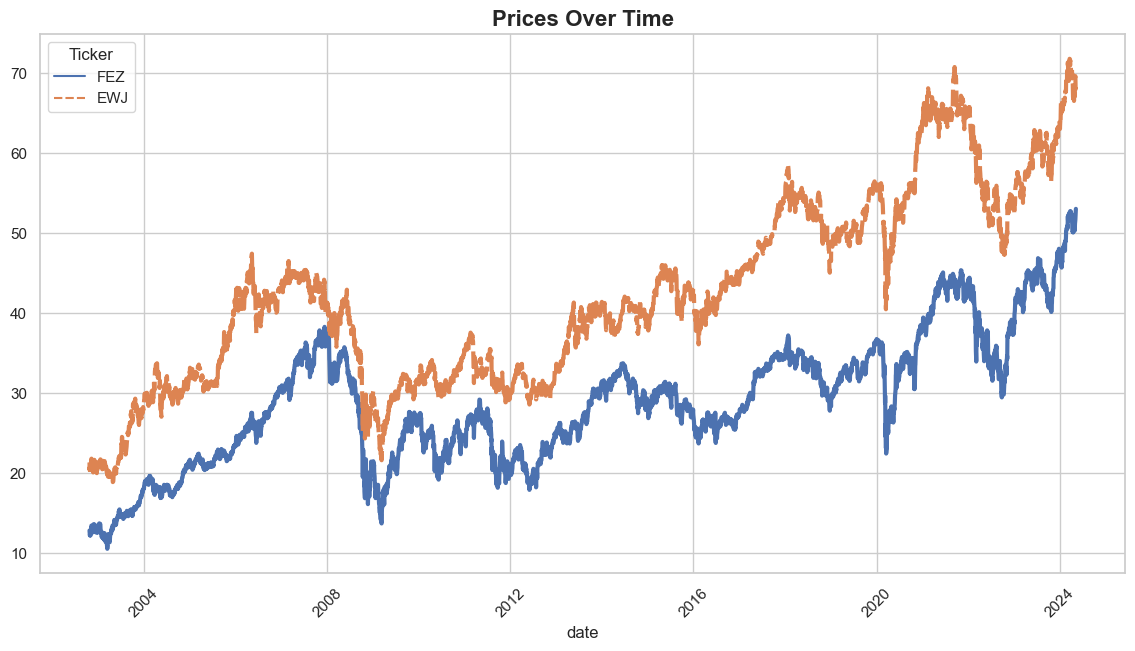

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.lineplot(data=prices, color='darkblue', linewidth=3, linestyle = '-')
title = f'Prices Over Time'
plt.title(title, fontsize=16, fontweight='bold')
plt.xticks(rotation=45)

plt.show()

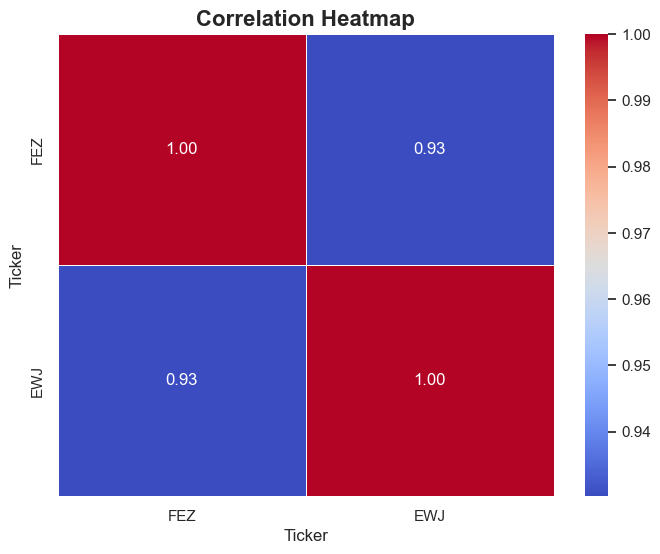

In [12]:
correlation = prices.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

## Returns Time Series Graph

In [13]:
rets = prices.pct_change().dropna()

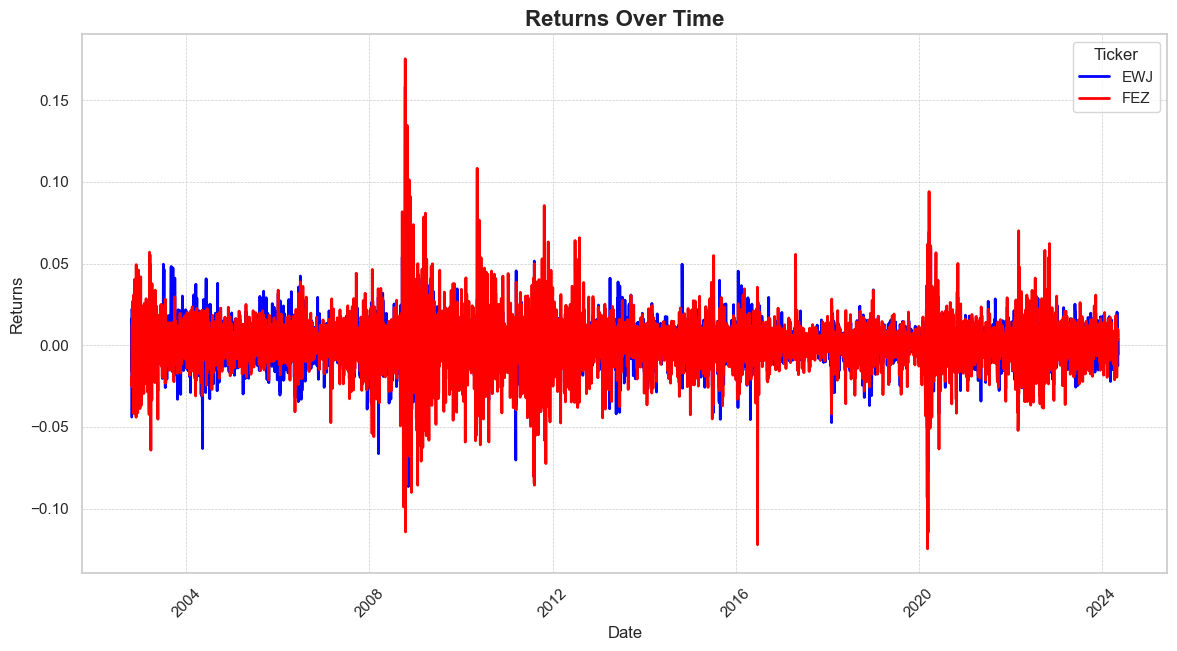

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

sns.lineplot(data=rets['EWJ'], color='blue', linewidth=2, label='EWJ')
sns.lineplot(data=rets['FEZ'], color='red', linewidth=2, label='FEZ')

plt.title('Returns Over Time', fontsize=16, fontweight='bold')

plt.xticks(rotation=45)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Returns', fontsize=12)

plt.legend(title='Ticker')

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


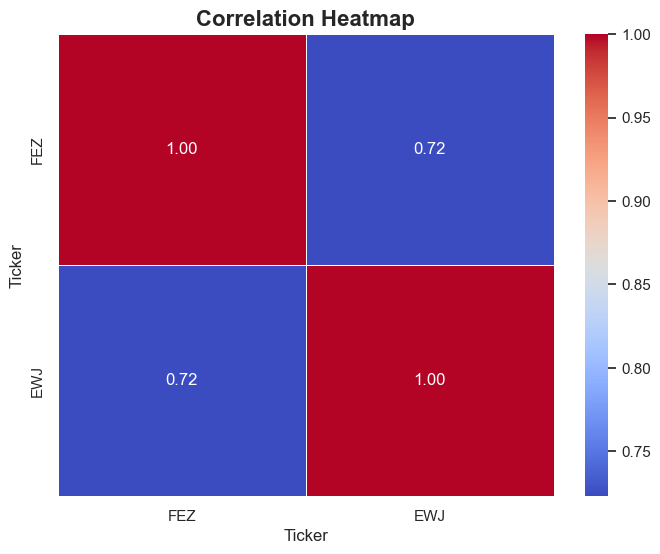

In [15]:
correlation = rets.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

Observations: The prices of FEZ and EWJ are highly correlated. Returns are not.

# Hypothesis Testing

## Mean Reversion

In [16]:
prices['Spread'] =prices['EWJ'] - prices['FEZ']

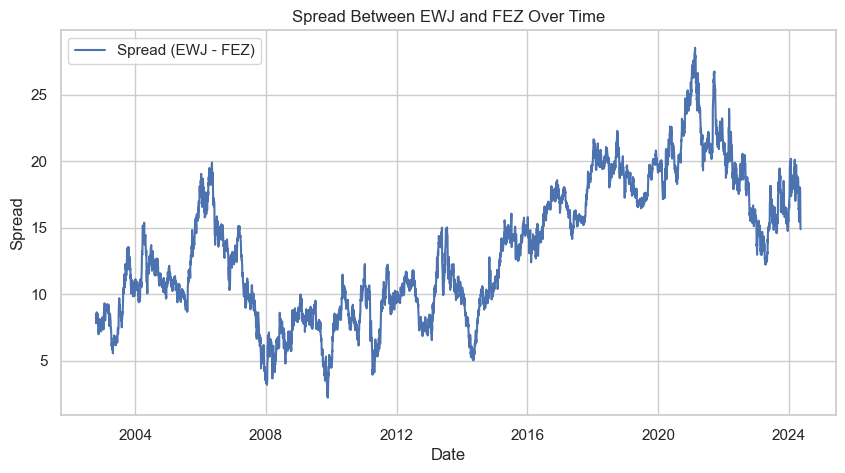

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(prices.index, prices['Spread'], label='Spread (EWJ - FEZ)')
plt.title('Spread Between EWJ and FEZ Over Time')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
adf_result = adfuller(prices['Spread'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.583047
p-value: 0.096552
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Observations: ADF tests determines whether time series is non-stationary. At a value of -2.5, and a p-value of 0.09, we do not reject the null hypothesis. Implies our data is non-stationary

<Figure size 1400x700 with 0 Axes>

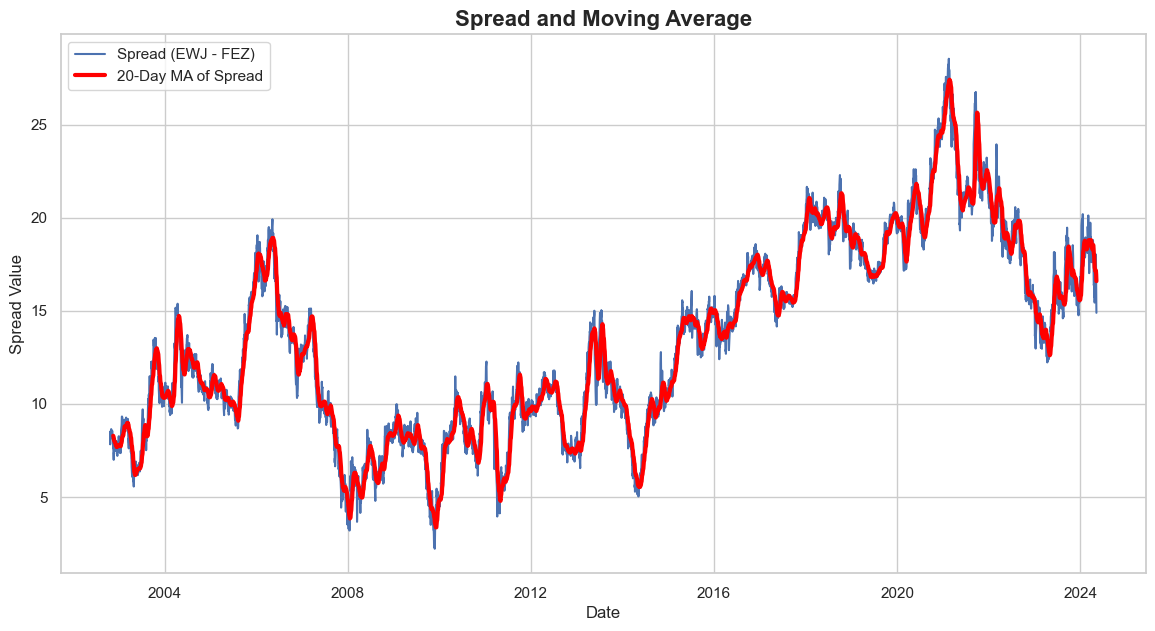

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

ma_window = 20
prices['MA_Spread'] = prices['Spread'].rolling(window=ma_window).mean()

plt.figure(figsize=(14, 7))
plt.plot(prices['Spread'], label='Spread (EWJ - FEZ)')
plt.plot(prices['MA_Spread'], label='20-Day MA of Spread', color='red', linewidth=3)
plt.title('Spread and Moving Average', fontweight='bold', fontsize = 16)
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.legend()
plt.show()

## Pairs Trading

In [20]:
score, pvalue, _ = coint(prices['EWJ'], prices['FEZ'])
print(f'Cointegration test p-value: {pvalue}')

Cointegration test p-value: 0.06895947333701793


Observation: Cointegration is seeing if the relationship between two variables is linear. Long term-equilibrium relationship. Idea is if it is, then they are suitable for pair trading. p-value is promising

In [21]:
prices.head()

Ticker,FEZ,EWJ,Spread,MA_Spread
date,,,,
2002-10-21,12.824625,21.332336,8.507711,NaN
2002-10-22,12.568131,20.394314,7.826182,NaN
2002-10-23,12.250083,20.727160,8.477077,NaN
2002-10-24,12.198788,20.394314,8.195526,NaN
2002-10-25,12.337286,20.848198,8.510912,NaN


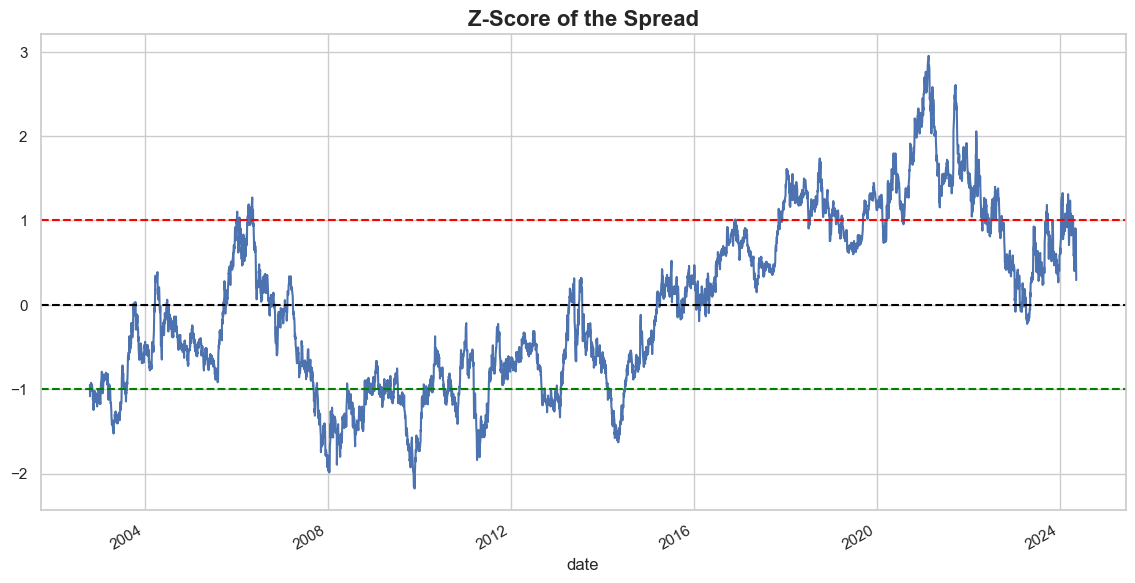

In [22]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
prices['Z-Score'] = zscore(prices['Spread'])
prices['Z-Score'].plot()

plt.title('Z-Score of the Spread', fontweight='bold', fontsize = 16)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.axhline(y=-1.0, color='green', linestyle='--')
plt.show()

In [23]:
data_for_later = prices

## Forecasting Spread

In [24]:
def plot_series(df, title='Spread over Time', forecast=None):
    plt.figure(figsize=(10, 5))
    plt.plot(df['Spread'], label='Spread', color = 'darkblue')
    if forecast is not None:
        plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
    plt.title(title)
    plt.ylabel('Spread')
    plt.legend()
    plt.show()

In [25]:
spread = pd.DataFrame(prices['Spread'])
spread.head()

,Spread
date,
2002-10-21,8.507711
2002-10-22,7.826182
2002-10-23,8.477077
2002-10-24,8.195526
2002-10-25,8.510912


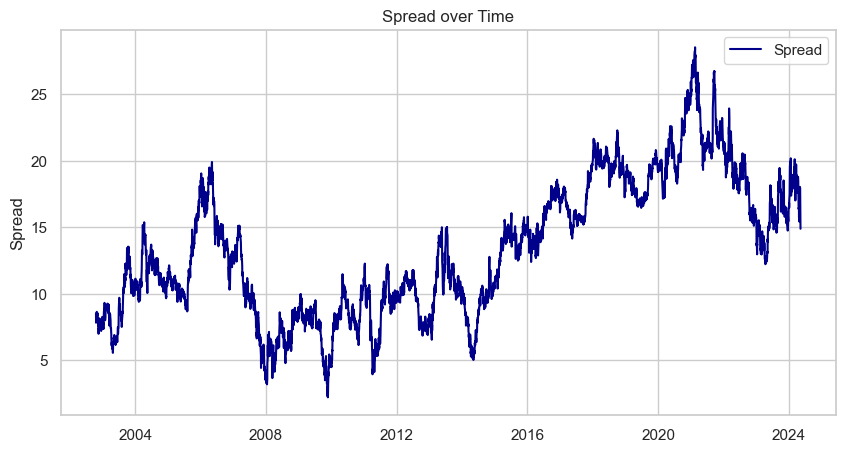

In [26]:
plot_series(spread)

In [27]:
#Normalizing
avg, dev = spread.mean(), spread.std()
spread = (spread - avg) / dev

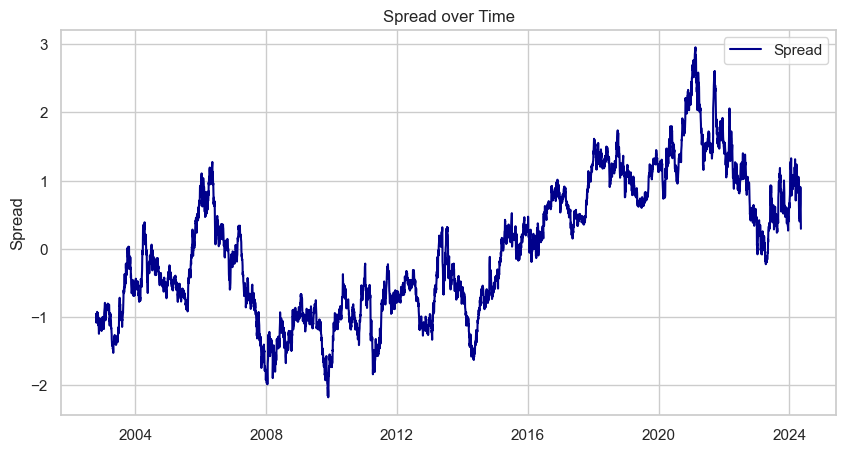

In [28]:
plot_series(spread)

In [29]:
# Removing Trend
spread = spread.diff().dropna()

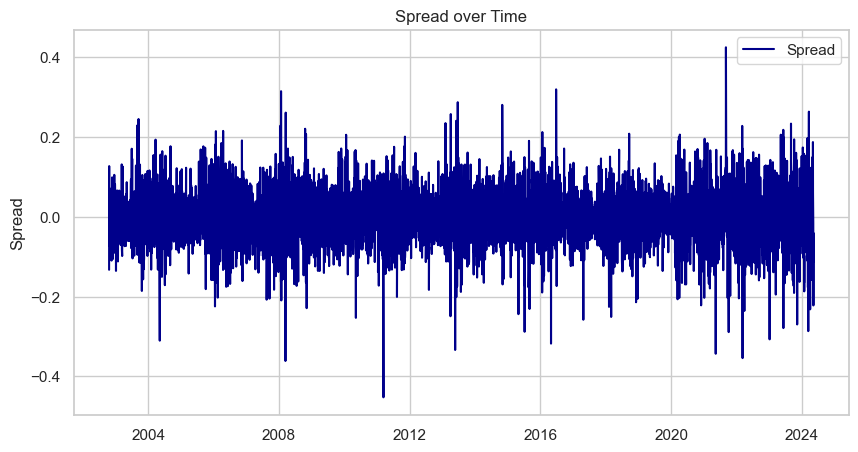

In [30]:
plot_series(spread)

In [31]:
# Removing increasing vol
annual_volatility = spread.groupby(spread.index.year).std()

In [32]:
spread_annual_vol = spread.index.map(lambda d: annual_volatility.loc[d.year])
spread_annual_vol = pd.Series(spread_annual_vol, index=spread.index).astype('float64')
spread_annual_vol

date
2002-10-22    0.057301
2002-10-23    0.057301
2002-10-24    0.057301
2002-10-25    0.057301
2002-10-28    0.057301
                ...   
2024-05-06    0.109089
2024-05-07    0.109089
2024-05-08    0.109089
2024-05-09    0.109089
2024-05-10    0.109089
Name: date, Length: 5425, dtype: float64

In [33]:
spraed = spread.divide(spread_annual_vol, axis=0)
spraed.head()

,Spread
date,
2002-10-22,-2.318010
2002-10-23,2.213815
2002-10-24,-0.957606
2002-10-25,1.072687
2002-10-28,-0.645582


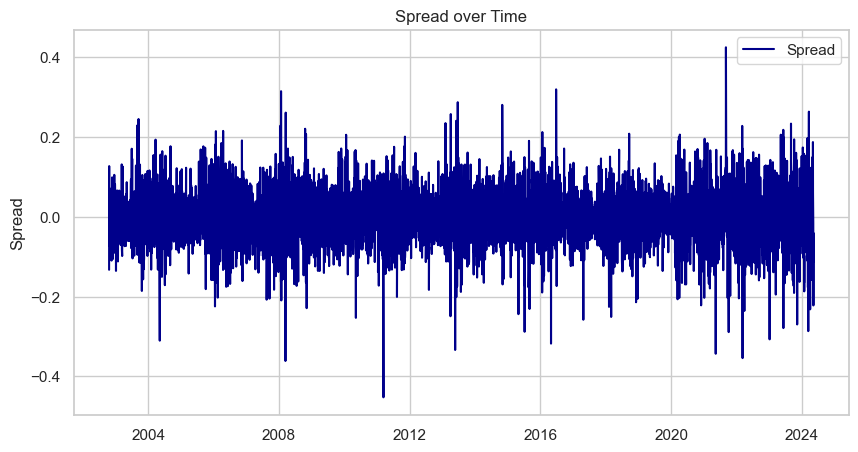

In [34]:
plot_series(spread)

In [35]:
month_avgs = spread.groupby(spread.index.month).mean()

month_avg_mapping = spread.index.month.map(month_avgs['Spread'])
spread = spread.subtract(month_avg_mapping, axis=0)


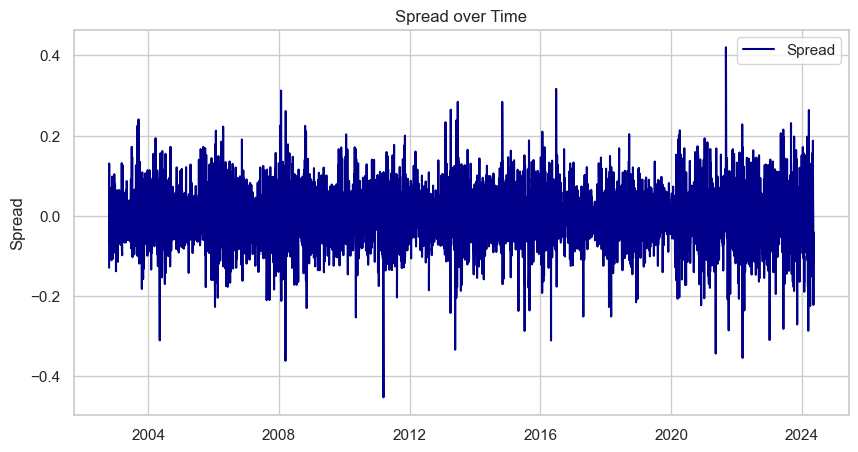

In [36]:
plot_series(spread)

In [37]:
adf_result = adfuller(spread)

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -19.303590
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Observations: After transformation, we can apply a time-series model. Forecast Spread

---

# Merging datasets

In [38]:
final_df = pd.read_excel('merged.xlsx', sheet_name = 'Sheet1')

In [39]:
print("Start Date", final_df.index.min())
print("Start Date", final_df.index.max())

Start Date 0
Start Date 5373


In [40]:
# Thinking if I should join raw prices into the main dataframe
prices.rename(columns = {'FEZ': 'FEZ Price', 'EWJ':'EWJ Price'}, inplace = True)
prices[['FEZ Price', 'EWJ Price']]

Ticker,FEZ Price,EWJ Price
date,,
2002-10-21,12.824625,21.332336
2002-10-22,12.568131,20.394314
2002-10-23,12.250083,20.727160
2002-10-24,12.198788,20.394314
2002-10-25,12.337286,20.848198
...,...,...
2024-05-06,51.720001,69.669998
2024-05-07,52.099998,68.910004
2024-05-08,52.360001,68.040001


In [41]:
final_df.set_index('date', inplace = True)
final_df.drop('Unnamed: 0', axis = 1, inplace = True)

In [42]:
final_df.head()

,EWJ,FEZ,JPN rate,EZ rate,EU GDP change,EU GDP,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change
date,,,,,,,,,,
2002-10-22,-0.043972,-0.020000,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-23,0.016321,-0.025306,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-24,-0.016058,-0.004187,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-25,0.022255,0.011354,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-28,0.000000,0.015384,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897


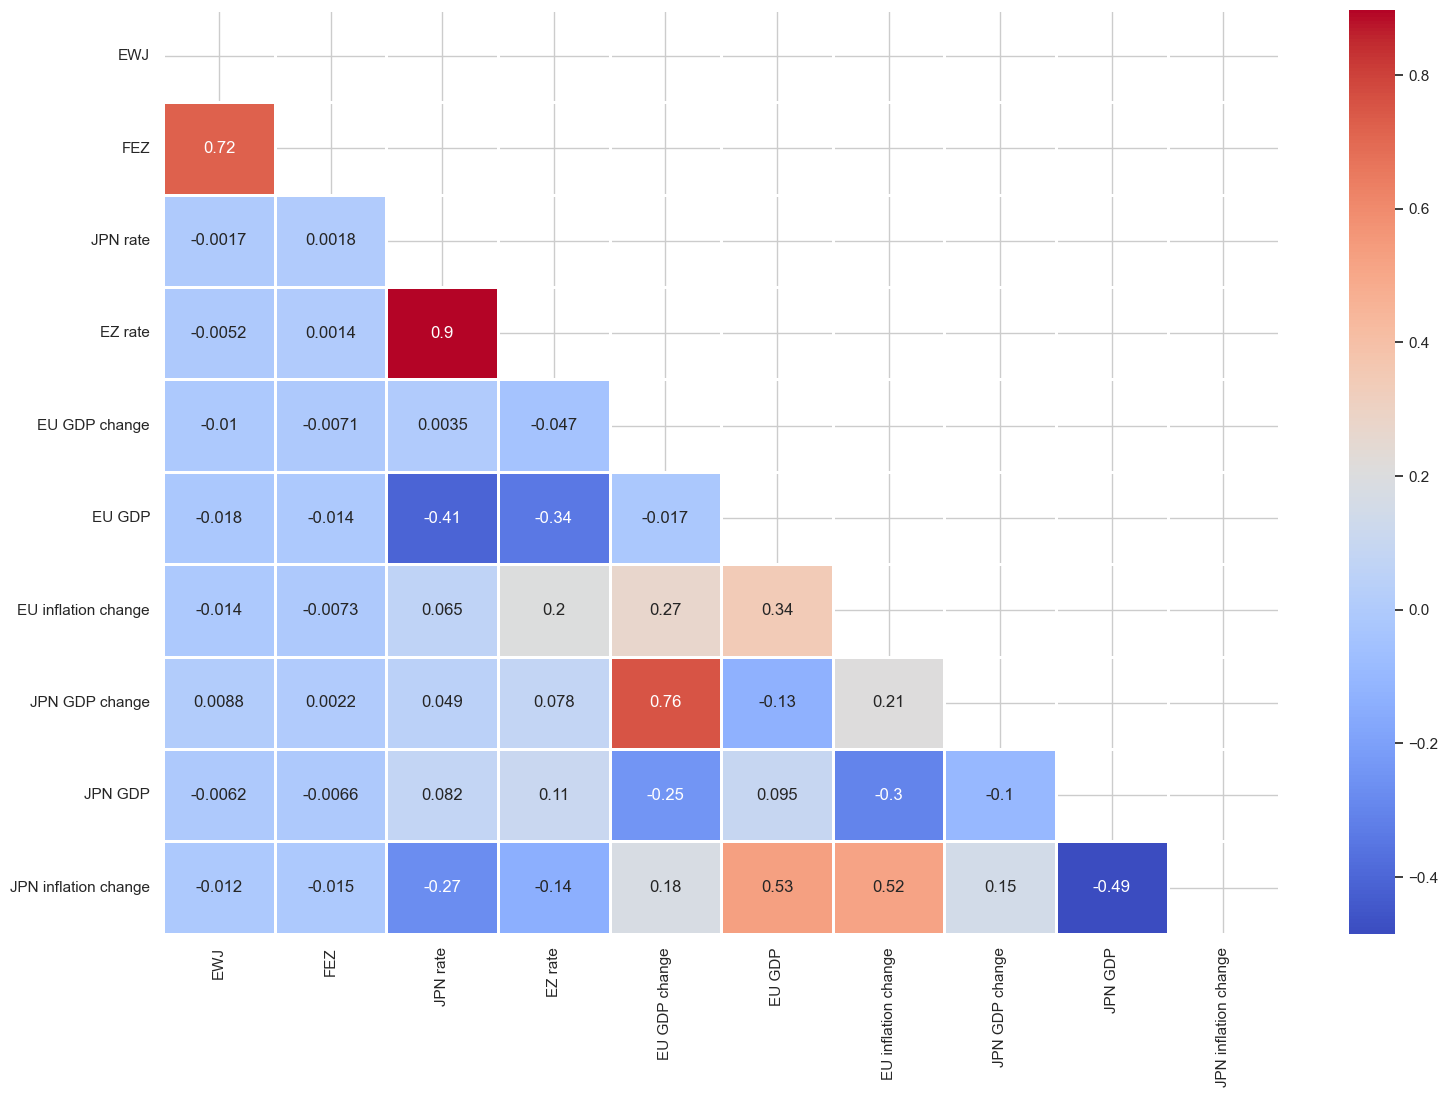

In [43]:
corr_df = final_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize = (18, 12))
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, mask=mask, annot=True, fmt='.2g', linewidths=1, cmap = 'coolwarm')
plt.show()

## Creating a hedge ratio using the Kalman Filter
Creating a Dynamic Hedge Ratio Between ETF Pairs Using the Kalman Filter
Source: https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/

What is a dynamic hedge ratio?
- A hedge ratio that attempts to capture the "true" hedge ratio as an unobserved hidden variable.
- We would take this to isolate the market beta between these ETFs.

In [44]:
#pip install pykalman

In [45]:
from __future__ import print_function
from pykalman import KalmanFilter

/var/folders/z0/f_sy62p51zl1gzqd2s1y4tfw0000gn/T/ipykernel_22374/2044345975.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colour_map = plt.cm.get_cmap('YlOrRd')
/var/folders/z0/f_sy62p51zl1gzqd2s1y4tfw0000gn/T/ipykernel_22374/2044345975.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  colourbar.ax.set_yticklabels(


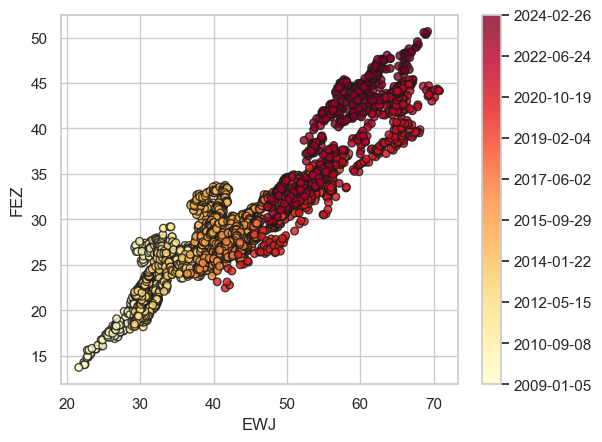

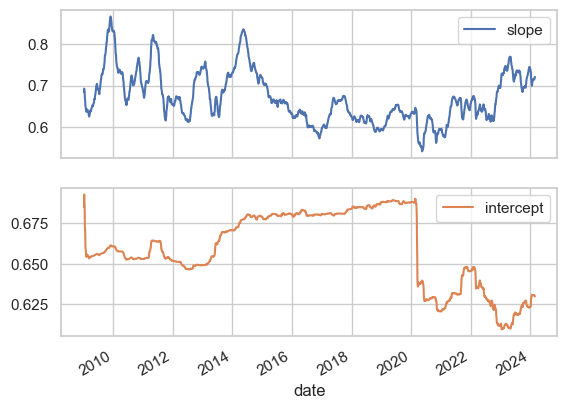

In [46]:
# Adapted code from this source: https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter/
def draw_date_coloured_scatterplot(etfs, prices):
    """
    Create a scatterplot of the two ETF prices, which is
    coloured by the date of the price to indicate the
    changing relationship between the sets of prices
    """
    # Create a yellow-to-red colourmap where yellow indicates
    # early dates and red indicates later dates
    plen = len(prices)
    colour_map = plt.cm.get_cmap('YlOrRd')
    colours = np.linspace(0.1, 1, plen)

    # Create the scatterplot object
    scatterplot = plt.scatter(
        prices[etfs[0]], prices[etfs[1]],
        s=30, c=colours, cmap=colour_map,
        edgecolor='k', alpha=0.8
    )

    # Add a colour bar for the date colouring and set the
    # corresponding axis tick labels to equal string-formatted dates
    colourbar = plt.colorbar(scatterplot)
    colourbar.ax.set_yticklabels(
        [str(p.date()) for p in prices[::plen//9].index]
    )
    plt.xlabel(prices.columns[0])
    plt.ylabel(prices.columns[1])
    plt.show()


def calc_slope_intercept_kalman(etfs, prices):
    """
    Utilise the Kalman Filter from the pyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack(
        [prices[etfs[0]], np.ones(prices[etfs[0]].shape)]
    ).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, state_covs = kf.filter(prices[etfs[1]].values)
    return state_means, state_covs


def draw_slope_intercept_changes(prices, state_means):
    """
    Plot the slope and intercept changes from the
    Kalman Filte calculated values.
    """
    pd.DataFrame(
        dict(
            slope=state_means[:, 0],
            intercept=state_means[:, 1]
        ), index=prices.index
    ).plot(subplots=True)
    plt.show()


if __name__ == "__main__":
    # Load the dataset
    file_path = 'etf_euro_jap_project_data.xlsx'
    prices_data = pd.read_excel(file_path, sheet_name='prices')

    # Parse dates and set the index
    prices_data['date'] = pd.to_datetime(prices_data['date'])
    prices_data.set_index('date', inplace=True)

    # Choose the ETF symbols to work with
    etfs = ['EWJ', 'FEZ']

    # Select the relevant columns for prices
    prices = prices_data[etfs]

    # Plot the date-coloured scatterplot
    draw_date_coloured_scatterplot(etfs, prices)

    # Calculate the Kalman Filter slope and intercept
    state_means, state_covs = calc_slope_intercept_kalman(etfs, prices)

    # Plot the slope and intercept changes
    draw_slope_intercept_changes(prices, state_means)

Interpretation:
- The first graph shows the price relationship in USD between EWJ and FEZ. As can see that both ETFs start relatively correlated and have a divergence as price increases. The is true in the intercept graph, which shows the intercept between these ETFs over time. 2020 specifically looked like a point where the historical relationship between these securities deteriorated.

## Combining datasets

In [47]:
data_for_later

Ticker,FEZ Price,EWJ Price,Spread,MA_Spread,Z-Score
date,,,,,
2002-10-21,12.824625,21.332336,8.507711,NaN,-0.951316
2002-10-22,12.568131,20.394314,7.826182,NaN,-1.084152
2002-10-23,12.250083,20.727160,8.477077,NaN,-0.957287
2002-10-24,12.198788,20.394314,8.195526,NaN,-1.012163
2002-10-25,12.337286,20.848198,8.510912,NaN,-0.950692
...,...,...,...,...,...
2024-05-06,51.720001,69.669998,17.949997,17.144499,0.889072
2024-05-07,52.099998,68.910004,16.810005,17.061499,0.666877
2024-05-08,52.360001,68.040001,15.680000,16.944999,0.446629


In [48]:
final_df

,EWJ,FEZ,JPN rate,EZ rate,EU GDP change,EU GDP,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change
date,,,,,,,,,,
2002-10-22,-0.043972,-0.020000,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-23,0.016321,-0.025306,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-24,-0.016058,-0.004187,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-25,0.022255,0.011354,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-28,0.000000,0.015384,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
...,...,...,...,...,...,...,...,...,...,...
2024-02-22,0.016374,0.015911,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-23,0.001597,0.000595,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-26,-0.000145,0.001189,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237


In [49]:
merged_data = pd.merge(data_for_later, final_df, left_on='date', right_on='date', how='inner')

In [50]:
merged_data

,FEZ Price,EWJ Price,Spread,MA_Spread,Z-Score,EWJ,FEZ,JPN rate,EZ rate,EU GDP change,EU GDP,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change
date,,,,,,,,,,,,,,,
2002-10-22,12.568131,20.394314,7.826182,NaN,-1.084152,-0.043972,-0.020000,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-23,12.250083,20.727160,8.477077,NaN,-0.957287,0.016321,-0.025306,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-24,12.198788,20.394314,8.195526,NaN,-1.012163,-0.016058,-0.004187,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-25,12.337286,20.848198,8.510912,NaN,-0.950692,0.022255,0.011354,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-28,12.527097,20.848198,8.321101,NaN,-0.987688,0.000000,0.015384,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,50.344189,68.900002,18.555813,18.292277,1.007151,0.016374,0.015911,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-23,50.374134,69.010002,18.635868,18.307043,1.022755,0.001597,0.000595,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-26,50.434017,69.000000,18.565983,18.366273,1.009133,-0.000145,0.001189,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237


---

# Implementing the trading strategy


In [51]:
merged_data.to_excel('final_dataset.xlsx', index = 'date')

### Explanation of Strategy
We will conduct a pairwise trading strategy based on the mean reversion of the spread between EWJ and FEZ using the z-score of the spread (EWJ - FEZ) as our signal.
Over the long-run, we expect the z-score to revert to historical levels between -1 < 0 < 1. When the z-score is negative, FEZ is overvalued relative to EWJ. Thus, we should long EWJ and short FEZ. Conversely, when the z-score is positive, EWJ is overvalued relative to FEZ, so we would short EWJ and long FEZ. 
  
Thus, our trading strategy will be as follows: 
1. Determine allocation. This will be the product of the total exposure we want and that trading day's z-score. This will give us a dynamic way to size the market. (trade signal = z-score)
2. Identify periods where the z-score is outside of historical bounds (i.e z-score < -1 or z-score > 1). This threshold will be dynamic so we can play around with the parameters of the trade to test its sensivity
3. Apply the Kalman filter to determine the appropriate hedging strategy

Assumptions: 
1. We are in a frictionless market
2. There are no transaction costs
3. There will be no haircuts on the trade as we will be putting forth our initial capital

Pitfalls we needed to take into account: 
1. Since we used the Kalman filter as the hedge ratio, we needed to recalculate the Kalman filter for each trading period. If we used the entire series, we would have incorporated bias into the filter as it evaluates all signals up to the current date.
2. The positions we build today are multiplied by the returns of the following day. This is because in real life, you would re-adjust your end-of-day position the beginning of the following day to account for closed markets. 

In [52]:
merged_data

,FEZ Price,EWJ Price,Spread,MA_Spread,Z-Score,EWJ,FEZ,JPN rate,EZ rate,EU GDP change,EU GDP,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change
date,,,,,,,,,,,,,,,
2002-10-22,12.568131,20.394314,7.826182,NaN,-1.084152,-0.043972,-0.020000,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-23,12.250083,20.727160,8.477077,NaN,-0.957287,0.016321,-0.025306,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-24,12.198788,20.394314,8.195526,NaN,-1.012163,-0.016058,-0.004187,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-25,12.337286,20.848198,8.510912,NaN,-0.950692,0.022255,0.011354,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
2002-10-28,12.527097,20.848198,8.321101,NaN,-0.987688,0.000000,0.015384,1.095,4.623465,1.271,8068.12,2.788,0.042,4182.85,-0.897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,50.344189,68.900002,18.555813,18.292277,1.007151,0.016374,0.015911,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-23,50.374134,69.010002,18.635868,18.307043,1.022755,0.001597,0.000595,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237
2024-02-26,50.434017,69.000000,18.565983,18.366273,1.009133,-0.000145,0.001189,0.710,3.024766,1.099,18977.63,2.737,0.855,4110.45,2.237


In [53]:
# Cleaning up merged data to retain only the values we will need
columns_to_retain = ['FEZ Price', 'EWJ Price', 'Z-Score']
df = merged_data[columns_to_retain]
df

,FEZ Price,EWJ Price,Z-Score
date,,,
2002-10-22,12.568131,20.394314,-1.084152
2002-10-23,12.250083,20.727160,-0.957287
2002-10-24,12.198788,20.394314,-1.012163
2002-10-25,12.337286,20.848198,-0.950692
2002-10-28,12.527097,20.848198,-0.987688
...,...,...,...
2024-02-22,50.344189,68.900002,1.007151
2024-02-23,50.374134,69.010002,1.022755
2024-02-26,50.434017,69.000000,1.009133


In [54]:
## Setting up the variables we want to have. 
# Constants
UPPERBOUND = 1
LOWERBOUND = -1
LONG = -50000000  # Using the minus as we go long when the spread is negative
MIN_CONSECUTIVE_DAYS = 3  # t, the minimum number of consecutive days to enter a trade

In [55]:
## Adding columns to the dataframe
data = df.copy()
data['long_size'] = data['Z-Score'] * LONG

## Long versus short
data['long_etf'] = np.where(data['Z-Score'] > UPPERBOUND, 'FEZ',
                            np.where(data['Z-Score'] < LOWERBOUND, 'EWJ', np.nan))

In [56]:
data.to_csv('backtesting_data.csv', index = True)

In [57]:
# Identify all periods where you'd like to enter a trade
t = 3 # miniumn number of consercutive days where "long_eft" has to be populated to enter a trade

# we will return this algorithm as long as data['long_etf'] has a value in the next row and the value of the number of consecutive cells in data['etf_long'] >= t. 
# when the next row of data['long_etf'] no longer has a value, we will exit the trade (and i will tell you how to do this)

# entering the trade
# step 1: check that long_etf has t or more consecutive values populated. 
# step 2: for the days that the trade is on: 
# calculate the returns on EWJ price
# calculate the returns on FEZ price
# calculate the hedge ratio for that day, using the kalman filter up until the previous day. 
# store kalman filter values in a new column: data['hedge_ratio']
# create data['allocation_long'] = data['Z-Score'] * LONG
# create data['allocation_short'] = data['hedge_ratio'] * LONG
# step 3: calculate daily PnL
# note: the data['long_etf']  column will tell us which is long and which is short. if 'EWJ' is long, then use 'EWJ Price' for the long position returns and 'FEZ Price' for short position
# if 'FEZ' is long, then use 'FEZ Price' for the long position returns and 'EWJ Price' for short position
# daily PnL should be calculated as: PCT change in long * yesterday's long position in data['allocation_long'] + pct change in short * yesterday's short position (contained in data['allocation_short'])
# make sure to store PCT change in long * yesterday's long position in data['longpnl'] and pct change in short * yesterday's short position in data['shortpnl']
# create data['dailypnl'] = data['longpnl'] + data['shortpnl']

# Exiting the trade
# report the consecutive pnl over the trading period
# report the date entered and the date exited
# report the mean daily PnL over the life of the trade
# calculate the percentage earned on the trade as follows: (culmulative returns) / (long capita allocation - short capital allocation)


In [58]:
def identify_trade_periods(data):
    """
    Identifies periods where the z-score is outside the defined bounds for at least MIN_CONSECUTIVE_DAYS consecutive days.
    """
    # Create a mask where true indicates that z-score is outside bounds
    conditions = (data['Z-Score'] > UPPERBOUND) | (data['Z-Score'] < LOWERBOUND)
    data['trade_condition'] = conditions

    # Identify consecutive days where trade conditions are met
    data['condition_cumsum'] = (data['trade_condition'] != data['trade_condition'].shift(1)).cumsum()
    trade_groups = data.groupby('condition_cumsum').cumcount() + 1

    # Only consider the groups that meet the trade_condition (True)
    data['condition_count'] = np.where(data['trade_condition'], trade_groups, 0)

    # Flag rows where trade can be executed (i.e., condition is met for at least MIN_CONSECUTIVE_DAYS)
    data['execute_trade'] = data['condition_count'] >= MIN_CONSECUTIVE_DAYS

    return data

# Process data to identify trade periods
processed_data = identify_trade_periods(data)
print(processed_data[['Z-Score', 'trade_condition', 'condition_count', 'execute_trade']].head(10))


             Z-Score  trade_condition  condition_count  execute_trade
date                                                                 
2002-10-22 -1.084152             True                1          False
2002-10-23 -0.957287            False                0          False
2002-10-24 -1.012163             True                1          False
2002-10-25 -0.950692            False                0          False
2002-10-28 -0.987688            False                0          False
2002-10-29 -0.937491            False                0          False
2002-10-30 -0.924812            False                0          False
2002-10-31 -0.998889            False                0          False
2002-11-01 -0.957214            False                0          False
2002-11-04 -0.980515            False                0          False


Notes on how we're applying the Kalman filter: 

1. Each time a new trading period starts (when execute_trade switches from False to True), we'll start a new Kalman filter calculation using only the data from that specific trading period. For the very first day of the trading period, the Kalman filter will use data up to the last day when execute_trade was False.

2. Data Gaps and Non-Trading Days: For each trading period, the Kalman filter is reset and recalculated daily using data only from the current trading period. This means we won't propagate hedge ratios from previous periods; each period's hedge ratio calculations are isolated to ensure they're based solely on data relevant to that specific period.

Ideally, we'd use all the historical data available to us up to t-1, but this is very computationally intensive over 20 years, so we will only be focusing on the periods where our strategy would indicate we should trade. 

In [59]:
def calculate_hedge_ratio(data, initial_state):
    """
    Calculate the dynamic hedge ratio using the Kalman Filter.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([data['EWJ Price'], np.ones(data['EWJ Price'].shape)]).T[:, np.newaxis]

    kf = KalmanFilter(
        n_dim_obs=1,
        n_dim_state=2,
        initial_state_mean=initial_state,
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )

    state_means, _ = kf.filter(data['FEZ Price'].values)
    return state_means[:, 0]  # Slopes as hedge ratios

# Process data to calculate hedge ratios during trading periods
def process_trading_periods(data):
    data['hedge_ratio'] = np.nan
    trading_indices = data.index[data['execute_trade']]
    
    for start, end in zip(trading_indices[:-1], trading_indices[1:]):
        if not data.loc[start, 'execute_trade']:  # Check if it's the beginning of a new trading period
            continue
        # Select data for the current trading period
        trading_data = data.loc[start:end]
        previous_day = data.loc[data.index[data.index < start][-1]]
        
        # Initial state for the Kalman filter from the last non-trade day
        initial_state = [0, 0]  # Placeholder for actual initial state logic
        hedge_ratios = calculate_hedge_ratio(trading_data, initial_state)
        data.loc[start:end, 'hedge_ratio'] = hedge_ratios
    
    return data


data = identify_trade_periods(data) 
processed_data = process_trading_periods(data)
print(processed_data[['Z-Score', 'execute_trade', 'hedge_ratio']].head(10))


             Z-Score  execute_trade  hedge_ratio
date                                            
2002-10-22 -1.084152          False          NaN
2002-10-23 -0.957287          False          NaN
2002-10-24 -1.012163          False          NaN
2002-10-25 -0.950692          False          NaN
2002-10-28 -0.987688          False          NaN
2002-10-29 -0.937491          False          NaN
2002-10-30 -0.924812          False          NaN
2002-10-31 -0.998889          False          NaN
2002-11-01 -0.957214          False          NaN
2002-11-04 -0.980515          False          NaN


In [66]:
def calculate_daily_pnl(data):
    """
    Calculate daily PnL based on trading positions and their respective returns.
    """
    # Calculate daily returns for each ETF
    data['FEZ_return'] = data['FEZ Price'].pct_change()
    data['EWJ_return'] = data['EWJ Price'].pct_change()

    # Initialize columns for PnL calculation
    data['long_pnl'] = 0
    data['short_pnl'] = 0
    data['total_pnl'] = 0
    data['long_allocation'] = 0
    data['short_allocation'] = 0
    data['capital_outlay'] = 0
    data['return_percent'] = 0

    # Prepare the hedge_ratio from the previous day to be used in calculations
    data['prev_hedge_ratio'] = data['hedge_ratio'].shift(1)
    data['prev_hedge_ratio'].fillna(method='bfill', inplace=True)

    # Identify rows where trades are executed
    trade_indices = data['execute_trade']

    # Calculate long and short allocations
    data.loc[trade_indices, 'long_allocation'] = LONG * data.loc[trade_indices, 'Z-Score']
    data.loc[trade_indices, 'short_allocation'] = data.loc[trade_indices, 'long_allocation'] * data.loc[trade_indices, 'prev_hedge_ratio']

    # Calculate capital outlay and return percent
    data.loc[trade_indices, 'capital_outlay'] = data.loc[trade_indices, 'long_allocation'] - data.loc[trade_indices, 'short_allocation']

    # Determine which ETF is long and which is short based on Z-Score
    long_ewj = data['Z-Score'] >= 0
    long_fez = data['Z-Score'] < 0

    # Calculate PnL for long and short positions based on the returns
    data.loc[trade_indices & long_ewj, 'long_pnl'] = data.loc[trade_indices & long_ewj, 'EWJ_return'] * data.loc[trade_indices & long_ewj, 'long_allocation']
    data.loc[trade_indices & long_ewj, 'short_pnl'] = data.loc[trade_indices & long_ewj, 'FEZ_return'] * -data.loc[trade_indices & long_ewj, 'short_allocation']
    
    data.loc[trade_indices & long_fez, 'long_pnl'] = data.loc[trade_indices & long_fez, 'FEZ_return'] * data.loc[trade_indices & long_fez, 'long_allocation']
    data.loc[trade_indices & long_fez, 'short_pnl'] = data.loc[trade_indices & long_fez, 'EWJ_return'] * -data.loc[trade_indices & long_fez, 'short_allocation']

    # Calculate the total daily PnL as the difference between long and short pnl
    data['total_pnl'] = data['long_pnl'] + data['short_pnl']

    # Calculate return percent using capital outlay as the denominator and total_pnl as the numerator
    data.loc[trade_indices, 'return_percent'] = (data.loc[trade_indices, 'total_pnl'] / data.loc[trade_indices, 'capital_outlay']) * 100

    return data

# Apply the function to calculate daily PnL
processed_data = calculate_daily_pnl(processed_data)
print(processed_data[['long_etf', 'long_allocation', 'short_allocation', 'capital_outlay', 'total_pnl', 'return_percent']].tail(10))

           long_etf  long_allocation  short_allocation  capital_outlay  \
date                                                                     
2024-02-14      FEZ     0.000000e+00      0.000000e+00    0.000000e+00   
2024-02-15      FEZ    -5.091784e+07     -3.635505e+07   -1.456278e+07   
2024-02-16      FEZ    -5.189032e+07     -3.705523e+07   -1.483509e+07   
2024-02-20      FEZ    -5.170132e+07     -3.684295e+07   -1.485837e+07   
2024-02-21      nan     0.000000e+00      0.000000e+00    0.000000e+00   
2024-02-22      FEZ     0.000000e+00      0.000000e+00    0.000000e+00   
2024-02-23      FEZ     0.000000e+00      0.000000e+00    0.000000e+00   
2024-02-26      FEZ    -5.045667e+07     -3.626458e+07   -1.419208e+07   
2024-02-27      nan     0.000000e+00      0.000000e+00    0.000000e+00   
2024-02-28      nan     0.000000e+00      0.000000e+00    0.000000e+00   

               total_pnl  return_percent  
date                                      
2024-02-14      0.000000 

In [67]:
processed_data['return_percent'].describe().T

count    5374.000000
mean       -0.007698
std         2.543891
min       -30.973530
25%         0.000000
50%         0.000000
75%         0.000000
max        22.466416
Name: return_percent, dtype: float64

In [69]:
processed_data['total_pnl'].sum()

20768899.791374326

# THIS IS WHERE I STOPPED - REST OF THE CODE IS ORIGINAL

---

In [68]:
### OLD

In [61]:
def calculate_hedge_ratio(df, index):
    """Calculate the hedge ratio using regression on the most recent log returns."""
    X = df['log_return_EWJ'].iloc[:index]  # Use all available data up to this point
    y = df['log_return_FEZ'].iloc[:index]
    X = sm.add_constant(X)  # Adding a constant for the intercept
    model = sm.OLS(y, X).fit()
    return model.params['log_return_EWJ']

def calculate_pnl(df, start_index, end_index, capital_ewj, capital_fez, direction):
    """Calculate the PnL for a trade period based on the capital invested."""
    opening_price_ewj = df['EWJ Price'].iloc[start_index]
    closing_price_ewj = df['EWJ Price'].iloc[end_index]
    opening_price_fez = df['FEZ Price'].iloc[start_index]
    closing_price_fez = df['FEZ Price'].iloc[end_index]

    # Calculate number of shares bought with the capital
    shares_ewj = capital_ewj / opening_price_ewj
    shares_fez = capital_fez / opening_price_fez

    # PnL calculations based on trade direction
    if direction == 'long EWJ / short FEZ':
        pnl_ewj = (closing_price_ewj - opening_price_ewj) * shares_ewj
        pnl_fez = (opening_price_fez - closing_price_fez) * shares_fez
    else:
        pnl_ewj = (opening_price_ewj - closing_price_ewj) * shares_ewj
        pnl_fez = (closing_price_fez - opening_price_fez) * shares_fez

    return pnl_ewj + pnl_fez

def zscore_trading_periods_dynamic_positions(df, lower_threshold, upper_threshold, total_capital):
    """Trading strategy based on Z-score with dynamic positions and hedge ratios."""
    df['log_return_EWJ'] = np.log(df['EWJ Price'] / df['EWJ Price'].shift(1))
    df['log_return_FEZ'] = np.log(df['FEZ Price'] / df['FEZ Price'].shift(1))
    df.dropna(inplace=True)  # Handle possible NaN values from log calculation

    periods = []
    current_period = {}
    in_position = False

    for i in range(1, len(df)):
        if not in_position:
            # Entry logic for long EWJ and short FEZ
            if df['Z-Score'].iloc[i] < lower_threshold:
                hedge_ratio = calculate_hedge_ratio(df, i)
                entry_zscore = df['Z-Score'].iloc[i]
                capital_ewj = total_capital / (1 + abs(hedge_ratio))
                capital_fez = total_capital - capital_ewj
                current_period = {
                    'start_date': df.index[i],
                    'direction': 'long EWJ / short FEZ',
                    'hedge_ratio': hedge_ratio,
                    'capital_EWJ': capital_ewj,
                    'capital_FEZ': capital_fez,
                    'open_index': i,
                    'entry_zscore': entry_zscore
                }
                in_position = True

            # Entry logic for short EWJ and long FEZ
            elif df['Z-Score'].iloc[i] > upper_threshold:
                hedge_ratio = calculate_hedge_ratio(df, i)
                entry_zscore = df['Z-Score'].iloc[i]
                capital_ewj = total_capital / (1 + abs(hedge_ratio))
                capital_fez = total_capital - capital_ewj
                current_period = {
                    'start_date': df.index[i],
                    'direction': 'short EWJ / long FEZ',
                    'hedge_ratio': hedge_ratio,
                    'capital_EWJ': capital_ewj,
                    'capital_FEZ': capital_fez,
                    'open_index': i,
                    'entry_zscore': entry_zscore
                }
                in_position = True

        # Exit logic for reverting back to entry Z-score
        elif in_position:
            if current_period['direction'] == 'long EWJ / short FEZ' and df['Z-Score'].iloc[i] >= current_period['entry_zscore']:
                current_period['end_date'] = df.index[i]
                current_period['PnL'] = calculate_pnl(df, current_period['open_index'], i, current_period['capital_EWJ'], current_period['capital_FEZ'], current_period['direction'])
                periods.append(current_period)
                in_position = False

            elif current_period['direction'] == 'short EWJ / long FEZ' and df['Z-Score'].iloc[i] <= current_period['entry_zscore']:
                current_period['end_date'] = df.index[i]
                current_period['PnL'] = calculate_pnl(df, current_period['open_index'], i, current_period['capital_EWJ'], current_period['capital_FEZ'], current_period['direction'])
                periods.append(current_period)
                in_position = False

    if in_position:
        current_period['end_date'] = df.index[-1]
        current_period['PnL'] = calculate_pnl(df, current_period['open_index'], len(df) - 1, current_period['capital_EWJ'], current_period['capital_FEZ'], current_period['direction'])
        periods.append(current_period)

    results_df = pd.DataFrame(periods)
    results_df['average_daily_pnl'] = results_df.apply(
        lambda x: x['PnL'] / (x['end_date'] - x['start_date']).days if (x['end_date'] - x['start_date']).days > 0 else 0, axis=1
    )

    return results_df

# Example usage
capital = 50000000
lower_threshold = -2.5
upper_threshold = -1
results_df = zscore_trading_periods_dynamic_positions(merged_data, lower_threshold, upper_threshold, capital)
results_df


,start_date,direction,hedge_ratio,capital_EWJ,capital_FEZ,open_index,entry_zscore,end_date,PnL,average_daily_pnl
0,2002-12-30,short EWJ / long FEZ,0.906587,2.622487e+07,2.377513e+07,29,-0.998599,2002-12-31,1.127103e+05,112710.277606
1,2003-01-16,short EWJ / long FEZ,0.839590,2.717997e+07,2.282003e+07,41,-0.990630,2003-01-31,-5.303483e+04,-3535.655155
2,2003-02-04,short EWJ / long FEZ,0.816933,2.751890e+07,2.248110e+07,53,-0.949490,2003-03-14,-3.931254e+05,-10345.404201
3,2003-03-24,short EWJ / long FEZ,0.900416,2.631003e+07,2.368997e+07,86,-0.941502,2003-03-25,6.057324e+05,605732.407369
4,2003-03-26,short EWJ / long FEZ,0.939085,2.578536e+07,2.421464e+07,88,-0.967412,2003-03-27,-1.030134e+05,-103013.435640
...,...,...,...,...,...,...,...,...,...,...
82,2013-02-06,short EWJ / long FEZ,0.931538,2.588610e+07,2.411390e+07,2572,-0.908222,2013-02-13,1.987842e+05,28397.736936
83,2013-02-14,short EWJ / long FEZ,0.930282,2.590295e+07,2.409705e+07,2578,-0.950961,2014-02-06,1.046918e+06,2932.542868
84,2014-02-07,short EWJ / long FEZ,0.900268,2.631208e+07,2.368792e+07,2825,-0.944014,2014-02-13,4.809763e+05,80162.714677
85,2014-02-18,short EWJ / long FEZ,0.900061,2.631495e+07,2.368505e+07,2831,-0.982007,2014-02-19,1.531860e+05,153186.028957


In [62]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
prices['Z-Score'] = zscore(prices['Spread'])
prices['Z-Score'].plot()

plt.title('Z-Score of the Spread', fontweight='bold', fontsize = 16)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=1.0, color='red', linestyle='--')
plt.axhline(y=-1.0, color='green', linestyle='--')
plt.show()

KeyError: 'Spread'

<Figure size 1400x700 with 0 Axes>

## Risk Analysis

### Result df

In [ ]:
def calculate_performance_metrics(df):
    """
    Calculate various performance and risk metrics for the strategy.

    Parameters:
    - df (DataFrame): DataFrame containing the PnL for each trading period.

    Returns:
    - metrics (dict): Dictionary containing various performance and risk metrics.
    """
    metrics = {}
    # Calculate total returns
    total_return = df['PnL'].sum()
    metrics['Total Return'] = total_return

    # Calculate annualized returns
    trading_days = (df['end_date'].max() - df['start_date'].min()).days
    annualized_return = (1 + total_return / total_capital) ** (252 / trading_days) - 1
    metrics['Annualized Return'] = annualized_return

    # Calculate Sharpe Ratio
    daily_returns = df['PnL'] / total_capital / df['PnL'].count()
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
    metrics['Sharpe Ratio'] = sharpe_ratio

    # Calculate Maximum Drawdown
    cumulative_pnl = df['PnL'].cumsum()
    drawdown = cumulative_pnl - cumulative_pnl.cummax()
    max_drawdown = drawdown.min()
    metrics['Maximum Drawdown'] = max_drawdown

    # Calculate Win Rate
    win_rate = (df['PnL'] > 0).mean()
    metrics['Win Rate'] = win_rate

    # Calculate Average Win and Loss
    average_win = df.loc[df['PnL'] > 0, 'PnL'].mean()
    average_loss = df.loc[df['PnL'] < 0, 'PnL'].mean()
    metrics['Average Win'] = average_win
    metrics['Average Loss'] = average_loss

    return metrics

# Example usage
total_capital = 50000000
metrics = calculate_performance_metrics(results_df)
metrics

### VaR and CVaR

In [ ]:
def calculate_var_cvar(df, confidence_level=0.95):
    """
    Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR) for the strategy.

    Parameters:
    - df (DataFrame): DataFrame containing the PnL for each trading period.
    - confidence_level (float): The confidence level for VaR and CVaR.

    Returns:
    - risk_metrics (dict): Dictionary containing VaR and CVaR.
    """
    daily_returns = df['PnL'] / total_capital
    var = np.percentile(daily_returns, (1 - confidence_level) * 100)
    cvar = daily_returns[daily_returns <= var].mean()

    risk_metrics = {
        'VaR': var,
        'CVaR': cvar
    }

    return risk_metrics

# Example usage
risk_metrics = calculate_var_cvar(results_df)
print(risk_metrics)


### Scenario Analysis

In [ ]:
merged_data

,FEZ Price,EWJ Price,Spread,MA_Spread,Z-Score,EWJ,FEZ,JPN rate,EZ rate,EU GDP change,...,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change,Adjusted_EWJ_returns,Adjusted_FEZ_returns,Net_daily_returns,Cumulative_returns,log_return_EWJ,log_return_FEZ
date,,,,,,,,,,,,,,,,,,,,,
2002-11-18,13.173453,20.394320,2.725331,8.223197,-0.185435,-0.030216,-0.005422,0.979,4.592368,1.271,...,2.788,0.042,4182.85,-0.897,-1.510787e+06,-155969.020455,-1.354818e+06,-2.972778e+06,-0.030682,-0.005437
2002-11-19,13.096505,20.091730,2.525949,8.181649,-0.231677,-0.014837,-0.005842,0.979,4.592368,1.271,...,2.788,0.042,4182.85,-0.897,-7.418474e+05,-168048.722801,-5.737986e+05,-3.546577e+06,-0.014948,-0.005858
2002-11-20,13.240144,20.606129,2.847691,8.126094,-0.157056,0.025603,0.010968,0.979,4.592368,1.271,...,2.788,0.042,4182.85,-0.897,1.280135e+06,315514.873403,9.646199e+05,-2.581957e+06,0.025280,0.010908
2002-11-21,13.583846,20.969231,2.749800,8.085587,-0.179760,0.017621,0.025959,0.979,4.592368,1.271,...,2.788,0.042,4182.85,-0.897,8.810440e+05,746785.765882,1.342582e+05,-2.447699e+06,0.017468,0.025628
2002-11-22,13.604369,20.908712,2.661755,8.025259,-0.200180,-0.002886,0.001511,0.979,4.592368,1.271,...,2.788,0.042,4182.85,-0.897,-1.442798e+05,43455.910076,-1.877357e+05,-2.635434e+06,-0.002890,0.001510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,50.344189,68.900002,1.375498,18.292277,-0.498498,0.016374,0.015911,0.710,3.024766,1.099,...,2.737,0.855,4110.45,2.237,8.187053e+05,457737.905456,3.609674e+05,2.122856e+07,0.016241,0.015786
2024-02-23,50.374134,69.010002,1.445334,18.307043,-0.482302,0.001597,0.000595,0.710,3.024766,1.099,...,2.737,0.855,4110.45,2.237,7.982628e+04,17111.585274,6.271469e+04,2.129128e+07,0.001595,0.000595
2024-02-26,50.434017,69.000000,1.355013,18.366273,-0.503249,-0.000145,0.001189,0.710,3.024766,1.099,...,2.737,0.855,4110.45,2.237,-7.246874e+03,34198.469216,-4.144534e+04,2.124983e+07,-0.000145,0.001188


In [ ]:
# Getting overnight interest rate
SAVE_DATA = True
startdate = '2002-11-18'
enddate = '2024-02-28'
startdate = pd.to_datetime(STARTDATE)
enddate = pd.to_datetime(ENDDATE)

ticks = ['ECBDFR']

eu_overnight = pdr.DataReader(ticks,'fred',startdate,enddate)
eu_overnight.index.name = 'date'
eu_overnight.index = pd.to_datetime(rates.index)

In [ ]:
eu_overnight

,ECBDFR
date,
1999-01-01,2.00
1999-01-02,2.00
1999-01-03,2.00
1999-01-04,2.75
1999-01-05,2.75
...,...
2024-05-09,4.00
2024-05-10,4.00
2024-05-11,4.00


In [ ]:
macro_data = pd.merge(eu_overnight, merged_data, left_on='date', right_on='date', how='inner')

In [ ]:
macro_data

,ECBDFR,FEZ Price,EWJ Price,Spread,MA_Spread,Z-Score,EWJ,FEZ,JPN rate,EZ rate,...,EU inflation change,JPN GDP change,JPN GDP,JPN inflation change,Adjusted_EWJ_returns,Adjusted_FEZ_returns,Net_daily_returns,Cumulative_returns,log_return_EWJ,log_return_FEZ
date,,,,,,,,,,,,,,,,,,,,,
2002-11-18,2.25,13.173453,20.394320,2.725331,8.223197,-0.185435,-0.030216,-0.005422,0.979,4.592368,...,2.788,0.042,4182.85,-0.897,-1.510787e+06,-155969.020455,-1.354818e+06,-2.972778e+06,-0.030682,-0.005437
2002-11-19,2.25,13.096505,20.091730,2.525949,8.181649,-0.231677,-0.014837,-0.005842,0.979,4.592368,...,2.788,0.042,4182.85,-0.897,-7.418474e+05,-168048.722801,-5.737986e+05,-3.546577e+06,-0.014948,-0.005858
2002-11-20,2.25,13.240144,20.606129,2.847691,8.126094,-0.157056,0.025603,0.010968,0.979,4.592368,...,2.788,0.042,4182.85,-0.897,1.280135e+06,315514.873403,9.646199e+05,-2.581957e+06,0.025280,0.010908
2002-11-21,2.25,13.583846,20.969231,2.749800,8.085587,-0.179760,0.017621,0.025959,0.979,4.592368,...,2.788,0.042,4182.85,-0.897,8.810440e+05,746785.765882,1.342582e+05,-2.447699e+06,0.017468,0.025628
2002-11-22,2.25,13.604369,20.908712,2.661755,8.025259,-0.200180,-0.002886,0.001511,0.979,4.592368,...,2.788,0.042,4182.85,-0.897,-1.442798e+05,43455.910076,-1.877357e+05,-2.635434e+06,-0.002890,0.001510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,4.00,50.344189,68.900002,1.375498,18.292277,-0.498498,0.016374,0.015911,0.710,3.024766,...,2.737,0.855,4110.45,2.237,8.187053e+05,457737.905456,3.609674e+05,2.122856e+07,0.016241,0.015786
2024-02-23,4.00,50.374134,69.010002,1.445334,18.307043,-0.482302,0.001597,0.000595,0.710,3.024766,...,2.737,0.855,4110.45,2.237,7.982628e+04,17111.585274,6.271469e+04,2.129128e+07,0.001595,0.000595
2024-02-26,4.00,50.434017,69.000000,1.355013,18.366273,-0.503249,-0.000145,0.001189,0.710,3.024766,...,2.737,0.855,4110.45,2.237,-7.246874e+03,34198.469216,-4.144534e+04,2.124983e+07,-0.000145,0.001188


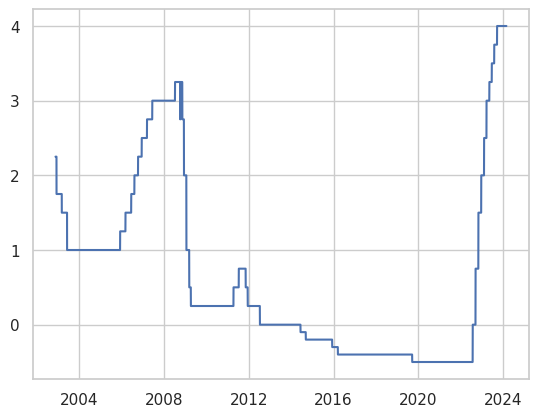

In [ ]:
plt.plot(macro_data.index, macro_data['ECBDFR'])

In [ ]:
# Going to use linear time series regression

In [ ]:
# Creating a dataset from the original dataset
macro_data.columns

Index(['ECBDFR', 'FEZ Price', 'EWJ Price', 'Spread', 'MA_Spread', 'Z-Score',
       'EWJ', 'FEZ', 'JPN rate', 'EZ rate', 'EU GDP change', 'EU GDP',
       'EU inflation change', 'JPN GDP change', 'JPN GDP',
       'JPN inflation change', 'Adjusted_EWJ_returns', 'Adjusted_FEZ_returns',
       'Net_daily_returns', 'Cumulative_returns', 'log_return_EWJ',
       'log_return_FEZ'],
      dtype='object')

In [ ]:
variables_to_study = ['ECBDFR', 'FEZ Price', 'EWJ Price']
macro_sub = macro_data[variables_to_study]

In [ ]:
macro_sub

,ECBDFR,FEZ Price,EWJ Price
date,,,
2002-11-18,2.25,13.173453,20.394320
2002-11-19,2.25,13.096505,20.091730
2002-11-20,2.25,13.240144,20.606129
2002-11-21,2.25,13.583846,20.969231
2002-11-22,2.25,13.604369,20.908712
...,...,...,...
2024-02-22,4.00,50.344189,68.900002
2024-02-23,4.00,50.374134,69.010002
2024-02-26,4.00,50.434017,69.000000


In [ ]:
df = macro_sub.copy()
# Create a lagged feature for EWJ Price
df['Lagged EWJ Price'] = df['EWJ Price'].shift(1)
df.dropna(inplace=True)

# Regression
from statsmodels.api import OLS

# Training data
y = df['EWJ Price']
X = df[['ECBDFR', 'FEZ Price', 'Lagged EWJ Price']]

# Adding a constant to the model
X = sm.add_constant(X)

# Fit the model
model = OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              EWJ Price   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 9.329e+05
Date:                Thu, 16 May 2024   Prob (F-statistic):               0.00
Time:                        23:47:48   Log-Likelihood:                -3886.9
No. Observations:                5354   AIC:                             7782.
Df Residuals:                    5350   BIC:                             7808.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0288      0.027  

These results indicate that time is a strong predictor of EWJ price, so we'll be using a Vector Auto Regression (VAR).

Inspiration source: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

In [ ]:
var_df = df.copy()
var_df = var_df[variables_to_study]
var_df = var_df.drop('FEZ Price', axis = 1)

In [ ]:
# Before we do this, must an ADF test
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
# Determining if the features are stationary
adf_test(var_df['ECBDFR'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.062543
p-value                    0.953044
# lags used               32.000000
# observations          5321.000000
critical value (1%)       -3.431580
critical value (5%)       -2.862083
critical value (10%)      -2.567059
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [ ]:
# We need to take the first order difference of the entire dataset and re-run the test
df_difference = var_df.diff()

In [ ]:
adf_test(df_difference['ECBDFR'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.709631e+00
p-value                 1.274048e-11
# lags used             3.300000e+01
# observations          5.319000e+03
critical value (1%)    -3.431580e+00
critical value (5%)    -2.862084e+00
critical value (10%)   -2.567059e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [ ]:
# Selecting the order of VAR
from statsmodels.tsa.vector_ar.var_model import VAR

# Check if the index needs conversion to PeriodIndex
if not isinstance(df_difference.index, pd.PeriodIndex):
    df_difference

model = VAR(endog=df_difference)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(df_difference)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()
# This code won't run

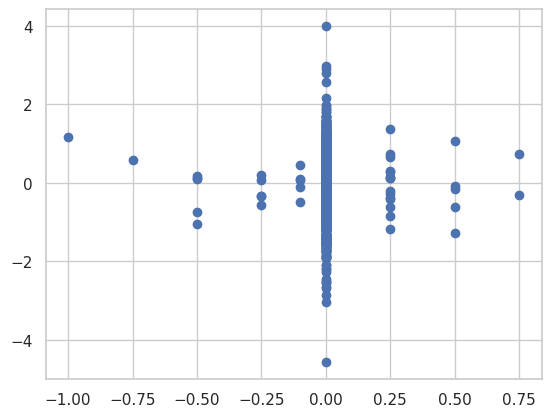

In [ ]:
plt.scatter(df_difference['ECBDFR'], df_difference['EWJ Price'])